In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.express as px

In [2]:
from tqdm import tqdm
import ast

In [3]:
column_names = [
    "track_id",         # Track ID
    "race_date",        # Race Date
    "race_number",      # Race Number
    "program_number",   # Program Number
    "weight_carried",   # Weight Carried
    "jockey",           # Jockey Name
    "odds",             # Odds
    "position_at_finish"# Finish Position
]

df_start = pd.read_csv("big-data-derby-2022\\nyra_start_table.csv", header=None, names=column_names)
df_race = pd.read_csv('big-data-derby-2022\\nyra_race_table.csv')

In [4]:
# add unique_id 
df_race['unique_id'] = df_race["track_id"] + "_" + df_race["race_date"] + "_" + df_race["race_number"].astype(str)
df_start['unique_id'] = df_start["track_id"] + "_" + df_start['race_date'] + "_" + df_start['race_number'].astype(str)

In [5]:
horse_tracking_path = "my-data\\horse-tracking-data-features\\"

In [14]:
def generate_final_positions(horse_tracking_data, finish_trakus_index):
    final_positions = horse_tracking_data[horse_tracking_data['trakus_index'] == finish_trakus_index]
    final_positions = final_positions.sort_values(by='cumulative_distance_travelled', ascending=False).reset_index(drop=True)
    position_dict = {position + 1: str(row['program_number']).strip() for position, row in final_positions.iterrows()}
    return position_dict

In [80]:
# generate unique_ids


In [118]:
def generate_positions_at_intervals(horse_tracking_data):
    intervals = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
    positions_at_intervals = {}
    for interval in intervals:
        first_instance = horse_tracking_data[horse_tracking_data['percent_race_completed'] >= interval].sort_values(by='trakus_index').iloc[0]['trakus_index']
        # print(f"First instance at {interval}%: {first_instance} and distance: {horse_tracking_data[horse_tracking_data['trakus_index'] == first_instance]['cumulative_distance_travelled'].values[0]}")
        positions_at_intervals[interval] = generate_final_positions(horse_tracking_data, first_instance)
    # positions_at_intervals[100] = generate_final_positions(horse_tracking_data, horse_tracking_data['trakus_index'].max())
    return positions_at_intervals

In [61]:
def find_finish_line_trakus_index(horse_tracking_data, finish_line_distance):
    finish_line_crossings = horse_tracking_data[
        horse_tracking_data['cumulative_distance_travelled'] >= finish_line_distance
    ]

    if not finish_line_crossings.empty:
        finish_trakus_index = finish_line_crossings['trakus_index'].min()
        return finish_trakus_index
    else:
        return None 

In [62]:
def generate_race_ending_index(track_geometry, df_race_details, unique_id):
    df_race_details = df_race_details[df_race_details['unique_id'] == unique_id]
    furlongs = df_race_details['distance_id'].values[0]
    distance = (furlongs/100)*201.168
    print(distance)
    for i in range(1, len(track_geometry)):
        if track_geometry.loc[i, 'cumulative_distance'] > distance:
            return i, distance
        else:
            return len(track_geometry)-1, distance

In [63]:
track_geometry_path = "my-data\\track-geometry\\"

In [ ]:
import os
from tqdm import tqdm

race_positions = {}

track_ids = df_race['unique_id'].unique()

for i, track_id in tqdm(enumerate(track_ids)):
    try:
        # Load horse tracking data for the current track_id
        file_path = os.path.join(horse_tracking_path, f"{track_id}.csv")
        horse_tracking_data = pd.read_csv(file_path)
        track_geometry_data = pd.read_csv(os.path.join(track_geometry_path, f"{track_id}.csv"))
        # Filter for ongoing race data
        horse_tracking_data = horse_tracking_data[horse_tracking_data['is_race_going'] == True]
        
        # Sort by 'trakus_index' and 'program_number'
        horse_tracking_data = horse_tracking_data.sort_values(by=['trakus_index', 'program_number'])
        
        # Calculate the total race distance
        race_distance = generate_race_ending_index(track_geometry_data, df_race, track_id)[1]
        
        # Compute the percentage of the race completed
        horse_tracking_data['percent_race_completed'] = (
            horse_tracking_data['cumulative_distance_travelled'] / race_distance * 100
        )
        
        # Generate positions at intervals (assuming function is defined)
        race_positions[track_id] = generate_positions_at_intervals(horse_tracking_data)
    
    except Exception as e:
        # Log error with details
        print(f"Error processing {track_id}: {e}")

In [120]:
intervals = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

In [121]:
df_positions = pd.DataFrame()
df_positions['track_id'] = track_ids

rows_to_drop = []  # List to track rows to drop

for idx, row in tqdm(df_positions.iterrows()):
    track_id = row['track_id']
    if track_id in race_positions:
        for interval in intervals:
            # Safely check that race_positions[track_id][interval] is scalar
            value = str(race_positions[track_id].get(interval))
            if value is not None:
                df_positions.loc[idx, 'interval_' + str(interval)] = value
            else:
                print(f"Missing value for track_id {track_id}, interval {interval}")
    else:
        rows_to_drop.append(idx)

# Drop rows after the loop
df_positions.drop(rows_to_drop, inplace=True)


2000it [00:05, 388.69it/s]


In [122]:
# save as csv
df_positions.to_csv("my-data\\race_positions_at_intervals.csv", index=False)

In [123]:
df_positions = pd.read_csv("my-data\\race_positions_at_intervals.csv")

In [124]:
track_ids = df_positions['track_id'].unique()

In [125]:
df_winner_or_not = pd.DataFrame()
df_winner_or_not['track_id'] = track_ids

In [126]:
winner = ast.literal_eval(df_positions[df_positions['track_id'] == track_ids[0]]['interval_100'].values[0]).get(1)

In [127]:
for track_id in tqdm(track_ids):
    winner = str(ast.literal_eval(df_positions[df_positions['track_id'] == track_id]['interval_100'].values[0]).get(1)).strip()
    for interval in intervals:
        leader = str(ast.literal_eval(df_positions[df_positions['track_id'] == track_id]['interval_' + str(interval)].values[0]).get(1)).strip()
        if winner == leader:
            df_winner_or_not.loc[df_winner_or_not['track_id'] == track_id, 'interval_' + str(interval)] = 1
        else:
            df_winner_or_not.loc[df_winner_or_not['track_id'] == track_id, 'interval_' + str(interval)] = 0

100%|██████████| 1994/1994 [00:36<00:00, 54.70it/s]


In [128]:
df_winner_or_not.head()

,track_id,interval_5,interval_10,interval_15,interval_20,interval_25,interval_30,interval_35,interval_40,interval_45,...,interval_55,interval_60,interval_65,interval_70,interval_75,interval_80,interval_85,interval_90,interval_95,interval_100
0,AQU_2019-01-01_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,AQU_2019-01-01_2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,AQU_2019-01-01_3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,AQU_2019-01-01_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,AQU_2019-01-01_5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [129]:
# find sum of 1s for each interval
sums_at_intervals = df_winner_or_not.sum()

In [130]:
sums_at_intervals

track_id        AQU_2019-01-01_1AQU_2019-01-01_2AQU_2019-01-01...
interval_5                                                  515.0
interval_10                                                 523.0
interval_15                                                 507.0
interval_20                                                 507.0
interval_25                                                 510.0
interval_30                                                 512.0
interval_35                                                 515.0
interval_40                                                 536.0
interval_45                                                 540.0
interval_50                                                 558.0
interval_55                                                 573.0
interval_60                                                 607.0
interval_65                                                 664.0
interval_70                                                 736.0
interval_7

In [131]:
# save as dictionary
sums_at_intervals_dict = sums_at_intervals.to_dict()
del sums_at_intervals_dict['track_id']
# divide by len of track_ids to get percentage
sums_at_intervals_dict = {k: v/len(track_ids) for k, v in sums_at_intervals_dict.items()}

In [132]:
sums_at_intervals_dict

{'interval_5': 0.25827482447342026,
 'interval_10': 0.2622868605817452,
 'interval_15': 0.2542627883650953,
 'interval_20': 0.2542627883650953,
 'interval_25': 0.25576730190571717,
 'interval_30': 0.2567703109327984,
 'interval_35': 0.25827482447342026,
 'interval_40': 0.2688064192577733,
 'interval_45': 0.2708124373119358,
 'interval_50': 0.279839518555667,
 'interval_55': 0.28736208625877635,
 'interval_60': 0.30441323971915746,
 'interval_65': 0.3329989969909729,
 'interval_70': 0.3691073219658977,
 'interval_75': 0.4282848545636911,
 'interval_80': 0.5090270812437312,
 'interval_85': 0.6103309929789368,
 'interval_90': 0.7286860581745236,
 'interval_95': 0.8505516549648947,
 'interval_100': 1.0}

In [133]:
# change key names to only 
sums_at_intervals_dict = {k.split('_')[1]: v for k, v in sums_at_intervals_dict.items()}

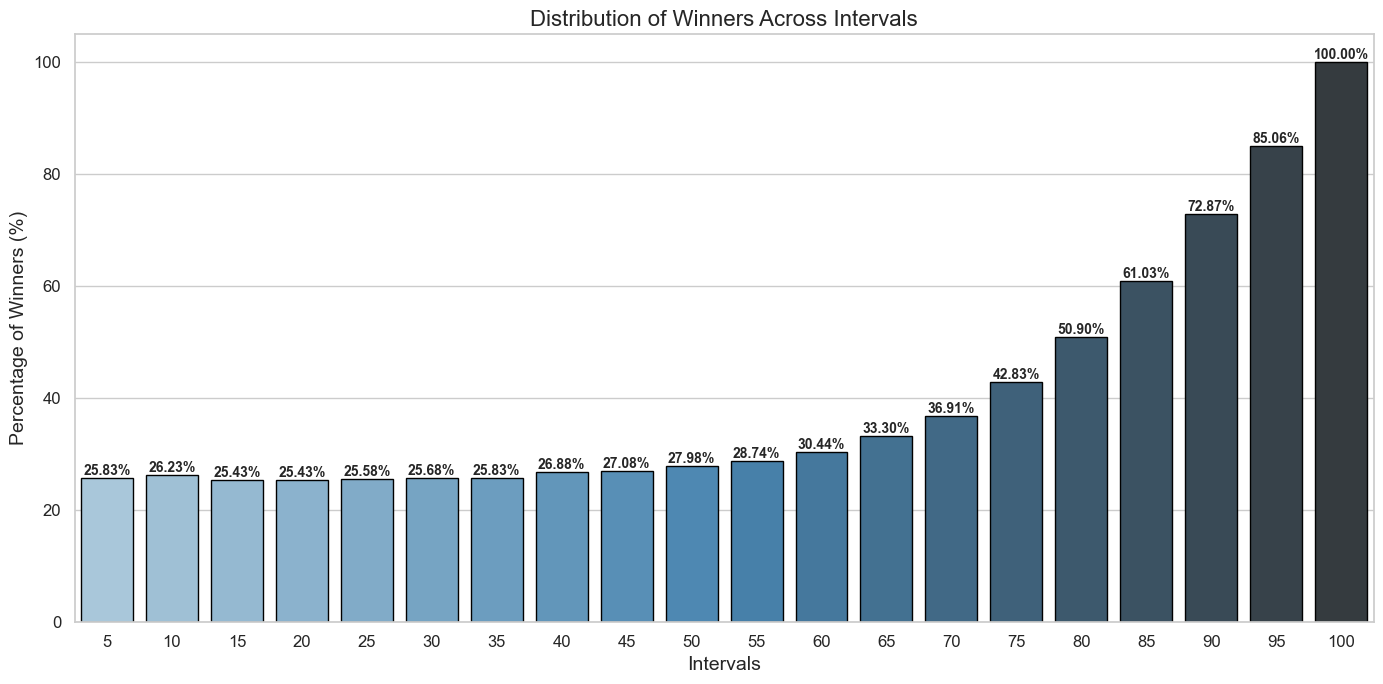

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the data to a DataFrame for better compatibility with Seaborn
data = pd.DataFrame({
    "Interval": list(sums_at_intervals_dict.keys()),
    "Percentage of Winners": [v * 100 for v in sums_at_intervals_dict.values()]
})

# Set the style
sns.set_theme(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    x="Interval",
    y="Percentage of Winners",
    data=data,
    palette="Blues_d",
    edgecolor="black"
)

# Add values on top of the bars
for bar in ax.patches:
    ax.annotate(
        f"{bar.get_height():.2f}%",
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# Customize the labels and title
ax.set_xlabel("Intervals", fontsize=14)
ax.set_ylabel("Percentage of Winners (%)", fontsize=14)
ax.set_title("Distribution of Winners Across Intervals", fontsize=16)

# Beautify ticks
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

# Final adjustments
plt.tight_layout()
plt.show()


In [139]:
path = "Average_Win_Proabilities_At_Intervals_full_399_races_test_set.csv"
df = pd.read_csv(path)

In [141]:
# rename Unnamed: 0 to Interval
df.rename(columns={'Unnamed: 0': 'Interval'}, inplace=True)

In [148]:
df

,Interval,win_probability
0,5,14.706617
1,10,16.657407
2,15,19.000988
3,20,21.288476
4,25,23.310877
5,30,25.063730
6,35,26.713523
7,40,28.392583
8,45,30.381231
9,50,32.782769


In [147]:
# multiple all values by 100 if they are less than 1
df = df.applymap(lambda x: x*100 if x < 1 else x)

C:\Users\Jayesh\AppData\Local\Temp\ipykernel_2476\3283789893.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x*100 if x < 1 else x)


In [151]:
sums_at_intervals_dict

{'5': 0.25827482447342026,
 '10': 0.2622868605817452,
 '15': 0.2542627883650953,
 '20': 0.2542627883650953,
 '25': 0.25576730190571717,
 '30': 0.2567703109327984,
 '35': 0.25827482447342026,
 '40': 0.2688064192577733,
 '45': 0.2708124373119358,
 '50': 0.279839518555667,
 '55': 0.28736208625877635,
 '60': 0.30441323971915746,
 '65': 0.3329989969909729,
 '70': 0.3691073219658977,
 '75': 0.4282848545636911,
 '80': 0.5090270812437312,
 '85': 0.6103309929789368,
 '90': 0.7286860581745236,
 '95': 0.8505516549648947,
 '100': 1.0}

In [152]:
# convert interval in df to string
df['Interval'] = df['Interval'].astype(str)

In [155]:
df

,Interval,win_probability
0,5,14.706617
1,10,16.657407
2,15,19.000988
3,20,21.288476
4,25,23.310877
5,30,25.063730
6,35,26.713523
7,40,28.392583
8,45,30.381231
9,50,32.782769


In [154]:
sums_at_intervals_dict

{'5': 0.25827482447342026,
 '10': 0.2622868605817452,
 '15': 0.2542627883650953,
 '20': 0.2542627883650953,
 '25': 0.25576730190571717,
 '30': 0.2567703109327984,
 '35': 0.25827482447342026,
 '40': 0.2688064192577733,
 '45': 0.2708124373119358,
 '50': 0.279839518555667,
 '55': 0.28736208625877635,
 '60': 0.30441323971915746,
 '65': 0.3329989969909729,
 '70': 0.3691073219658977,
 '75': 0.4282848545636911,
 '80': 0.5090270812437312,
 '85': 0.6103309929789368,
 '90': 0.7286860581745236,
 '95': 0.8505516549648947,
 '100': 1.0}

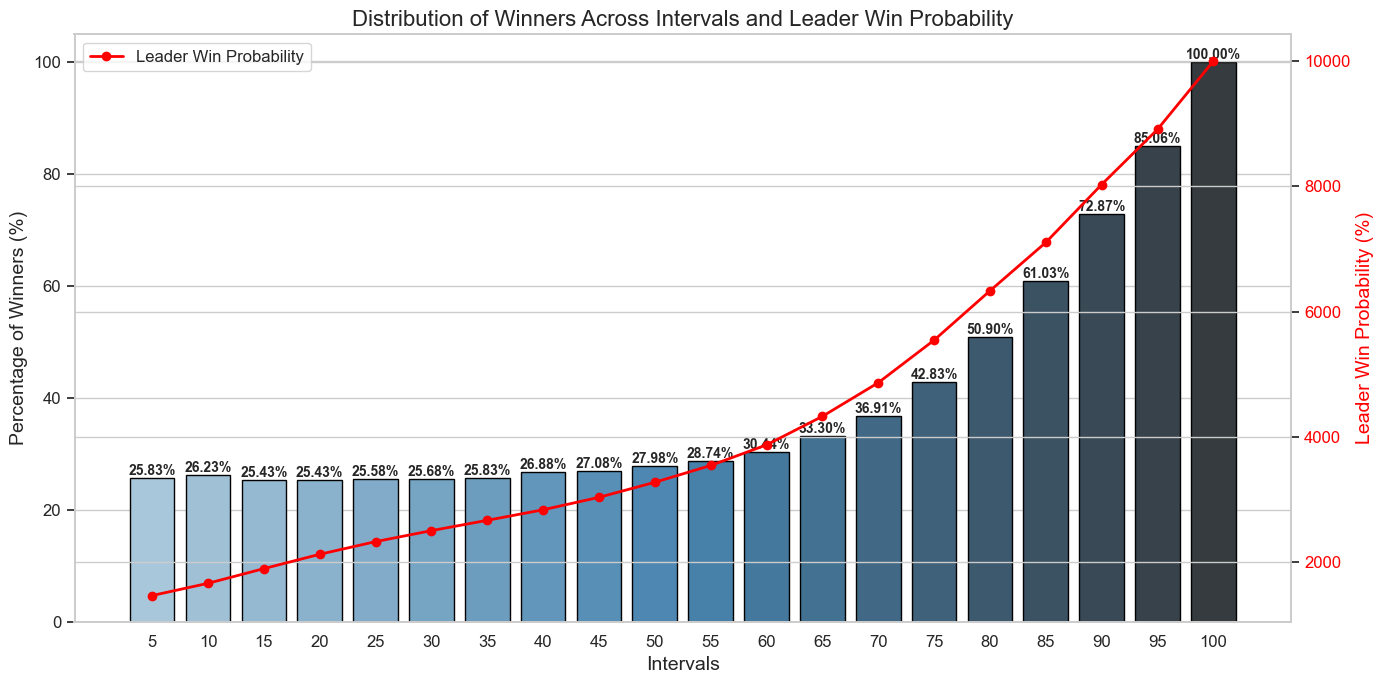

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your original data for percentage of winners in intervals
data = pd.DataFrame({
    "Interval": list(sums_at_intervals_dict.keys()),
    "Percentage of Winners": [v * 100 for v in sums_at_intervals_dict.values()]
})

# Your model's win probability for each interval (as given)
leader_win_prob = df.copy()

# Set the style
sns.set_theme(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    x="Interval",
    y="Percentage of Winners",
    data=data,
    palette="Blues_d",
    edgecolor="black"
)

# Add values on top of the bars
for bar in ax.patches:
    ax.annotate(
        f"{bar.get_height():.2f}%",
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# Overlay the leader's win probability as a line plot
ax2 = ax.twinx()  # This creates a second y-axis
ax2.plot(
    leader_win_prob["Interval"],
    leader_win_prob["win_probability"] * 100,  # Convert to percentage
    color="red", marker="o", label="Leader Win Probability", lw=2
)

# Add a label for the second y-axis
ax2.set_ylabel("Leader Win Probability (%)", fontsize=14, color="red")
ax2.tick_params(axis="y", labelsize=12, labelcolor="red")

# Customize the labels and title
ax.set_xlabel("Intervals", fontsize=14)
ax.set_ylabel("Percentage of Winners (%)", fontsize=14)
ax.set_title("Distribution of Winners Across Intervals and Leader Win Probability", fontsize=16)

# Beautify ticks
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

# Add a legend for the line plot
ax2.legend(fontsize=12, loc="upper left")

# Final adjustments
plt.tight_layout()
plt.show()


c:\Users\Jayesh\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jayesh\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jayesh\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jayesh\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

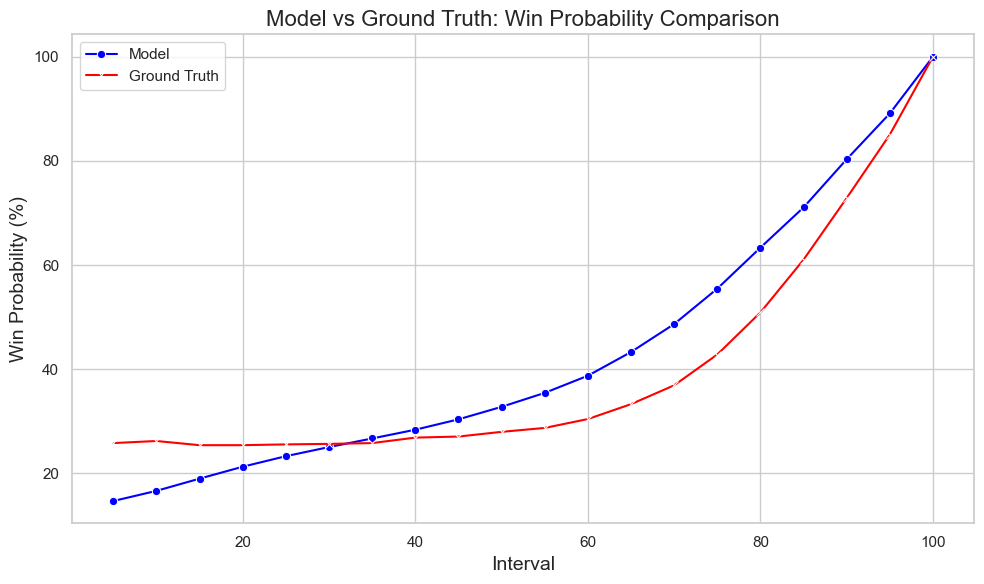

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your model's win probability DataFrame
model_data = {
    "Interval": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
    "Win_Probability": [14.706617, 16.657407, 19.000988, 21.288476, 23.310877, 25.063730, 26.713523, 28.392583, 30.381231, 32.782769, 
                        35.462303, 38.753808, 43.303407, 48.671701, 55.465612, 63.341849, 71.063227, 80.306885, 89.112132, 100.000000]
}

df_model = pd.DataFrame(model_data)

# Your ground truth dictionary
ground_truth = {
    '5': 0.25827482447342026,
    '10': 0.2622868605817452,
    '15': 0.2542627883650953,
    '20': 0.2542627883650953,
    '25': 0.25576730190571717,
    '30': 0.2567703109327984,
    '35': 0.25827482447342026,
    '40': 0.2688064192577733,
    '45': 0.2708124373119358,
    '50': 0.279839518555667,
    '55': 0.28736208625877635,
    '60': 0.30441323971915746,
    '65': 0.3329989969909729,
    '70': 0.3691073219658977,
    '75': 0.4282848545636911,
    '80': 0.5090270812437312,
    '85': 0.6103309929789368,
    '90': 0.7286860581745236,
    '95': 0.8505516549648947,
    '100': 1.0
}

# Convert ground truth dictionary to DataFrame and multiply by 100
df_ground_truth = pd.DataFrame(list(ground_truth.items()), columns=["Interval", "Ground_Truth"])
df_ground_truth["Ground_Truth"] = df_ground_truth["Ground_Truth"] * 100

# Ensure 'Interval' columns are of the same type (integer)
df_model["Interval"] = df_model["Interval"].astype(int)
df_ground_truth["Interval"] = df_ground_truth["Interval"].astype(int)

# Merge the model DataFrame and ground truth DataFrame
df = pd.merge(df_model, df_ground_truth, on="Interval")

# Set the style for the plot
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot both lines on the same graph
sns.lineplot(x="Interval", y="Win_Probability", data=df, label="Model", marker="o", color="blue")
sns.lineplot(x="Interval", y="Ground_Truth", data=df, label="Ground Truth", marker="x", color="red")

# Customize the labels and title
plt.xlabel("Interval", fontsize=14)
plt.ylabel("Win Probability (%)", fontsize=14)
plt.title("Model vs Ground Truth: Win Probability Comparison", fontsize=16)

# Show the legend
plt.legend()

# Final adjustments
plt.tight_layout()
plt.show()
